In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import math

Load options and trends files

In [2]:
# options = pd.read_csv("../csv/options/raw/2015-16options.csv")
# options = pd.read_csv("../csv/options/raw/data.csv")
options = pd.read_csv("../csv/options/cleaned/options.csv")

In [3]:
trends = pd.read_csv("../csv/trends/input.csv")

In [4]:
pruned_trends = trends
pruned_trends["date"] = pd.to_datetime(trends["date"])
pruned_trends.head()

,date,0,1,2,3,4,5,6,7,8,...,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974
0,2015-01-02 09:00:00,37.0,30.0,55.0,49.0,18.0,47.0,22.0,30.0,12.0,...,47.0,35.0,60.0,57.0,29.0,40.0,29.0,0.0,34.0,60.0
1,2015-01-03 09:00:00,47.0,53.0,95.0,39.0,29.0,40.0,23.0,42.0,12.0,...,43.0,32.0,56.0,42.0,29.0,39.0,15.0,0.0,39.0,57.0
2,2015-01-04 09:00:00,41.0,33.0,65.0,41.0,28.0,49.0,38.0,39.0,11.0,...,38.0,25.0,51.0,29.0,31.0,38.0,13.0,0.0,39.0,60.0
3,2015-01-05 09:00:00,38.0,49.0,43.0,41.0,19.0,71.0,30.0,36.0,5.0,...,42.0,38.0,93.0,70.0,34.0,51.0,22.0,0.0,30.0,51.0
4,2015-01-06 09:00:00,59.0,38.0,100.0,45.0,21.0,53.0,23.0,57.0,6.0,...,47.0,34.0,86.0,77.0,34.0,56.0,25.0,0.0,30.0,53.0


In [5]:
pruned_trends["date"] = pruned_trends["date"].apply(lambda x: pd.Timestamp(x.date()))
pruned_trends = pruned_trends.set_index("date")
pruned_trends = pruned_trends / 100

In [6]:
pruned_trends.head()

,0,1,2,3,4,5,6,7,8,9,...,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.37,0.30,0.55,0.49,0.18,0.47,0.22,0.30,0.12,0.04,...,0.47,0.35,0.60,0.57,0.29,0.40,0.29,0.0,0.34,0.60
2015-01-03,0.47,0.53,0.95,0.39,0.29,0.40,0.23,0.42,0.12,0.18,...,0.43,0.32,0.56,0.42,0.29,0.39,0.15,0.0,0.39,0.57
2015-01-04,0.41,0.33,0.65,0.41,0.28,0.49,0.38,0.39,0.11,0.21,...,0.38,0.25,0.51,0.29,0.31,0.38,0.13,0.0,0.39,0.60
2015-01-05,0.38,0.49,0.43,0.41,0.19,0.71,0.30,0.36,0.05,0.08,...,0.42,0.38,0.93,0.70,0.34,0.51,0.22,0.0,0.30,0.51
2015-01-06,0.59,0.38,1.00,0.45,0.21,0.53,0.23,0.57,0.06,0.10,...,0.47,0.34,0.86,0.77,0.34,0.56,0.25,0.0,0.30,0.53


In [7]:
options["date"] = pd.to_datetime(options["date"])
options["exdate"] = pd.to_datetime(options["exdate"])
options = options[(options["volume"] > 0) & (options["date"] <= pruned_trends.index.max())]

In [8]:
options.head()

,date,exdate,cp_flag,strike_price,volume,impl_volatility,delta,gamma,vega,theta,dte,impl_volatility_x
28,2015-01-05,2015-01-09,C,190000,9,0.351564,0.950105,0.010412,2.928393,-26.81932,4,0.347783
29,2015-01-06,2015-01-09,C,190000,30,0.387712,0.950041,0.013891,2.176366,-35.17571,3,0.351564
31,2015-01-06,2015-01-09,C,191000,72,0.346814,0.944486,0.016040,2.362663,-36.00574,3,0.331030
32,2015-01-05,2015-01-09,C,192000,31,0.322698,0.940545,0.013093,3.361140,-28.13116,4,0.317701
33,2015-01-06,2015-01-09,C,192000,30,0.331786,0.930463,0.019611,2.823542,-41.79280,3,0.322698


In [9]:
options["volume"] = options["volume"] - options["volume"].mean()
options["impl_volatility"] = options["impl_volatility"] - options["impl_volatility"].mean()
options["delta"] = options["delta"] - options["delta"].mean()
options["gamma"] = options["gamma"] - options["gamma"].mean()
options["vega"] = options["vega"] - options["vega"].mean()
options["theta"] = options["theta"] - options["theta"].mean()
options["impl_volatility_x"] = options["impl_volatility_x"] - options["impl_volatility_x"].mean()

In [10]:
options.head()

,date,exdate,cp_flag,strike_price,volume,impl_volatility,delta,gamma,vega,theta,dte,impl_volatility_x
28,2015-01-05,2015-01-09,C,190000,-1069.293641,0.111997,0.917181,-0.005350,-31.154606,-6.737658,4,0.113884
29,2015-01-06,2015-01-09,C,190000,-1048.293641,0.148145,0.917117,-0.001871,-31.906633,-15.094048,3,0.117665
31,2015-01-06,2015-01-09,C,191000,-1006.293641,0.107247,0.911562,0.000278,-31.720336,-15.924078,3,0.097131
32,2015-01-05,2015-01-09,C,192000,-1047.293641,0.083131,0.907621,-0.002669,-30.721859,-8.049498,4,0.083802
33,2015-01-06,2015-01-09,C,192000,-1048.293641,0.092219,0.897539,0.003849,-31.259457,-21.711138,3,0.088799


In [11]:
def setup_options_input(options_df, numrows):
    pruned_options = options_df.sample(numrows)
    pruned_options = pruned_options.drop(["exdate", "volume"], axis=1)
    pruned_options = pd.get_dummies(pruned_options, columns=["cp_flag"])
    pruned_options = pruned_options.set_index("date")
    df = pruned_options.apply(lambda x: pd.concat([x, pruned_trends.loc[pd.Timestamp(x.name)]], axis=0), axis=1)
    return df.drop(["impl_volatility"], axis=1).to_numpy(), df["impl_volatility"].to_numpy()

In [12]:
x, y = setup_options_input(options, 100000)

In [13]:
x.shape

(100000, 1984)

In [14]:
# pruned_options = options[options["volume"] > 0]
# pruned_options = pruned_options.drop(["secid", "symbol", "exdate", "volume", "delta", "gamma", "vega", "theta", "optionid", "index_flag", "issuer", "exercise_style"], axis=1)
# pruned_options = pd.get_dummies(pruned_options, columns=["cp_flag"])
# pruned_options = pruned_options.set_index("date")
# df = pruned_options.apply(lambda x: pd.concat([x, pruned_trends.loc[pd.Timestamp(x.name)]], axis=0), axis=1)
# x, y = df.drop(["impl_volatility"], axis=1).to_numpy(), df["impl_volatility"].to_numpy()

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1984, activation='linear'),
    # tf.keras.layers.Dense(1984*2, activation='linear'),
    # tf.keras.layers.Dense(1984*4, activation='linear'),
    # tf.keras.layers.Dense(1984*2, activation='linear'),
    # tf.keras.layers.Dense(1984, activation='linear'),
    # tf.keras.layers.Dense(1984, activation='relu'),
    # tf.keras.layers.Dense(1984*2, activation='relu'),
    # tf.keras.layers.Dense(1984*4, activation='relu'),
    # tf.keras.layers.Dense(1984*2, activation='relu'),
    # tf.keras.layers.Dense(1984, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [25]:
model.compile(
    # optimizer=keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9,),
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=[
        keras.metrics.MeanAbsolutePercentageError(),
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanSquaredError()
             ]
)

In [26]:
model.fit(
    x,
    y,
    batch_size=64,
    epochs=10, # seems like enough to reach the the minimum loss
    shuffle=True,
    verbose=1,
    use_multiprocessing=True,
    workers=12,
    validation_split=0.25
)

Epoch 1/10
1172/1172 [==============================] - 35s 29ms/step - loss: 2238.6433 - mean_absolute_percentage_error: 18237842.0000 - mean_absolute_error: 2238.6433 - mean_squared_error: 10892747.0000 - val_loss: 641.1252 - val_mean_absolute_percentage_error: 4385964.0000 - val_mean_absolute_error: 641.1252 - val_mean_squared_error: 435865.6875
Epoch 2/10
1172/1172 [==============================] - 33s 28ms/step - loss: 1403.5730 - mean_absolute_percentage_error: 17043720.0000 - mean_absolute_error: 1403.5730 - mean_squared_error: 3439148.0000 - val_loss: 173.3743 - val_mean_absolute_percentage_error: 1188291.3750 - val_mean_absolute_error: 173.3743 - val_mean_squared_error: 31930.3535
Epoch 3/10
1172/1172 [==============================] - 33s 28ms/step - loss: 843.2460 - mean_absolute_percentage_error: 7736570.0000 - mean_absolute_error: 843.2460 - mean_squared_error: 1258769.7500 - val_loss: 2287.3713 - val_mean_absolute_percentage_error: 15622422.0000 - val_mean_absolute_error

In [27]:
print(model.trainable_variables)

[<tf.Variable 'dense_5/kernel:0' shape=(1984, 1984) dtype=float32, numpy=
array([[ 1.3742602e-04, -3.3465047e-05, -2.9271891e-05, ...,
         3.2190601e-05,  1.9390922e-05,  1.3746295e-04],
       [ 2.1409720e-02,  3.8886327e-02, -6.0967695e-02, ...,
        -7.0626676e-02, -8.9518502e-02,  1.7962019e-01],
       [ 3.4050629e-02,  1.9886307e-02,  9.6268699e-02, ...,
        -1.2740672e-02,  7.2214514e-02,  6.7068875e-02],
       ...,
       [-1.8613629e-02,  3.3360317e-02,  3.5910413e-02, ...,
         2.2521572e-02, -1.3993690e-02, -4.8805665e-02],
       [-4.3195911e-02,  3.3907644e-02, -2.2825409e-02, ...,
        -4.6882514e-02, -1.5743285e-02, -4.7014844e-02],
       [-5.9276115e-02,  2.6627993e-02, -2.8643792e-02, ...,
         2.6632935e-02, -1.9392904e-02, -5.4823626e-02]], dtype=float32)>, <tf.Variable 'dense_5/bias:0' shape=(1984,) dtype=float32, numpy=
array([-0.02778054,  0.00782526,  0.00472989, ..., -0.00959372,
        0.00192546, -0.03229241], dtype=float32)>, <tf.Var

(array([5.1800e+02, 5.4460e+03, 1.1356e+04, 1.3709e+04, 1.4135e+04,
        1.1961e+04, 9.3310e+03, 7.0540e+03, 5.2920e+03, 4.0710e+03,
        3.2560e+03, 2.4230e+03, 1.9320e+03, 1.5010e+03, 1.2570e+03,
        1.0410e+03, 8.4700e+02, 6.2000e+02, 5.4900e+02, 4.6700e+02,
        4.1400e+02, 3.3300e+02, 3.0900e+02, 2.7300e+02, 2.4600e+02,
        2.1100e+02, 1.5400e+02, 1.5700e+02, 1.2600e+02, 1.0100e+02,
        7.9000e+01, 8.3000e+01, 8.2000e+01, 7.3000e+01, 5.1000e+01,
        5.0000e+01, 4.9000e+01, 4.1000e+01, 2.9000e+01, 3.5000e+01,
        3.0000e+01, 2.3000e+01, 2.9000e+01, 2.4000e+01, 2.3000e+01,
        1.5000e+01, 1.1000e+01, 1.8000e+01, 9.0000e+00, 8.0000e+00,
        1.7000e+01, 1.0000e+01, 8.0000e+00, 1.1000e+01, 6.0000e+00,
        6.0000e+00, 5.0000e+00, 7.0000e+00, 4.0000e+00, 7.0000e+00,
        3.0000e+00, 5.0000e+00, 0.0000e+00, 5.0000e+00, 1.0000e+00,
        6.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 2.00

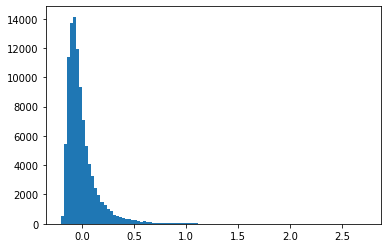

In [74]:
plt.hist(y, bins=100)
# plt.xlim(0, 0.5)

In [96]:
from tqdm.notebook import tqdm

In [97]:
y_preds = np.vstack([model.predict(x[i*64:(i+1)*64]) for i in tqdm(range(1563))]).flatten()

  0%|          | 0/1563 [00:00<?, ?it/s]

In [100]:
y.shape

(100000,)

In [102]:
y_preds = y_preds.flatten()

In [ ]:
plt.hist(y_preds.flatten(), bins=np.linspace(0, 1, 11), alpha=0.3)
plt.hist(y, bins=np.linspace(0, 1, 11), alpha=0.3)
plt.xlim(0, 1)

In [71]:
model.predict(x[[10, 20, 234, 763, 1237, 54736, 23452]])

array([[0.02106535],
       [0.03205708],
       [0.0197807 ],
       [0.05575758],
       [0.05327338],
       [0.04243129],
       [0.07145941]], dtype=float32)

In [72]:
y[[10, 20, 234, 763, 1237, 54736, 23452]]

array([-0.13474656, -0.07756556, -0.08052756,  0.12103444, -0.01051956,
       -0.04553256, -0.06033456])

In [24]:
model.save("./mape_loss_3")

2022-04-17 15:28:10.585568: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./mape_loss_3/assets


In [25]:
# modell = tf.keras.models.load_model("./initial_model_2")
modell = tf.keras.models.load_model("./mape_loss_2")

In [26]:
opt_test = pd.read_csv("../csv/options/raw/2017-18options.csv")


KeyboardInterrupt



In [ ]:
x_test, y_test = setup_options_input(opt_test, 200000)

In [22]:
modell.evaluate(x_test, y_test)

6250/6250 [==============================] - 103s 16ms/step - loss: 39.2194 - mean_absolute_percentage_error: 39.2194 - mean_absolute_error: 0.2684 - mean_squared_error: 0.1707


[39.219417572021484,
 39.219417572021484,
 0.26837822794914246,
 0.17069818079471588]

In [15]:
modell.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1979)              3918420   
                                                                 
 dense_17 (Dense)            (None, 3958)              7836840   
                                                                 
 dense_18 (Dense)            (None, 3958)              15669722  
                                                                 
 dense_19 (Dense)            (None, 1979)              7834861   
                                                                 
 dense_20 (Dense)            (None, 1)                 1980      
                                                                 
Total params: 35,261,823
Trainable params: 35,261,823
Non-trainable params: 0
_________________________________________________________________


In [39]:
y_predict = modell.predict(x_test)

In [ ]:
plt.plot(y_test - y_predict)